# Living Polymerization – CSTR Operation

## Theory

A living polymerization is a type of chain-growth polymerization in which the number of polymer chains remains constant. In practice, this means that the only reactions considered are initiation and propagation, while termination and transfer reactions are negligible. Assuming that both the initiation and propagation steps are first-order with respect to the monomer and the active center, the transient balances are as follows:

\begin{align*}
\frac{\textrm{d}[I]}{\textrm{d}t}   & = \frac{1}{\tau}\left([I]_{in} - [I]\right) - k_i [I] [M] \\
\frac{\textrm{d}[P_1]}{\textrm{d}t} & = \frac{1}{\tau}\left([P_1]_{in} - [P_1]\right) + (k_i [I] - k_p [P_1]) [M] \\
\frac{\textrm{d}[P_n]}{\textrm{d}t} & = \frac{1}{\tau}\left([P_n]_{in} - [P_n]\right) + k_p ([P_{n-1}] - [P_{n}]) [M], \;n \ge 2 \\
\frac{\textrm{d}[M]}{\textrm{d}t}   & = \frac{1}{\tau}\left([M]_{in} - [M]\right) - (k_i [I] + k_p \sum_{k=1}^\infty [P_k] )[M]
\end{align*}

## Numerical Solution

Let us implement a method to numerically evaluate $p_k$ as a function of the parameters $v$ and $r$.


In [25]:
%matplotlib widget
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

First, we write a function to compute the time derivative of the ODE system, i.e. $\dot{y}(t, y)$.

In [26]:
def balances_cstr(t: float,
                  C: np.ndarray,
                  Cin: np.ndarray,
                  ki: float,
                  kp: float,
                  tau: float
                  ) -> np.ndarray:
    r"""Molar balances for living polymerization in a single CSTR.

    Parameters
    ----------
    t : float
        Time.
    C : np.ndarray
        Concentration vector.
    Cin : np.ndarray
        Inlet concentration vector.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    tau : float
        Average residence time.

    Returns
    -------
    np.ndarray
        Time derivative of the concentration vector.
    """
    # Unpack the concentration vector
    I = C[0]
    P = C[1:-1]
    M = C[-1]

    # Allocate derivative vector
    Cdot = np.empty_like(C)
    # Pdot is a view of Cdot; updating Pdot updates Cdot
    Pdot = Cdot[1:-1]

    # Compute reaction rates
    Cdot[0] = -ki*I*M
    Pdot[0] = ki*I*M - kp*M*P[0]
    Pdot[1:] = kp*M*(P[0:-1] - P[1:])
    Cdot[-1] = -(ki*I + kp*P.sum())*M

    # Add in/outflow
    Cdot += (Cin - C)/tau

    return Cdot

In [27]:
def calc_ydot(t: float,
              y: np.ndarray,
              Cin1: np.ndarray,
              ki: float,
              kp: float,
              tau: float,
              ncstr: int
              ) -> np.ndarray:
    """Derivative of the state vector, dy/dt.

    Parameters
    ----------
    t : float
        Time.
    y : np.ndarray
        State vector.
    Cin1 : np.ndarray
        Inlet concentration vector of 1st CSTR.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    tau : float
        Average residence time.
    ncstr : int
        Number of CSTRs.

    Returns
    -------
    np.ndarray
        Time derivative of the state vector.
    """
    # Reshape the state vector to a matrix C[cstr, species]
    C = y.reshape((ncstr, -1))
    
    # Allocate derivative vector
    ydot = np.empty_like(y)
    Cdot = ydot.reshape((ncstr, -1))

    # Solve each CSTR (can be parallelized) 
    for i in range(ncstr):
        if i == 0:
            Cin = Cin1
        else:
            Cin = C[i-1, :]
        Cdot[i, :] = balances_cstr(t, C[i, :], Cin, ki, kp, tau)
    
    return ydot

Then, we perform the numerical integration using a suitable ODE solver. This system is non-stiff (do you know why?), therefore we can use an explicit scheme.

In [60]:
def solve_model(Iin: float,
                Min: float,
                ki: float,
                kp: float,
                tau: float,
                ncstr: int,
                tend: float
                ) -> tuple[np.ndarray, np.ndarray]:
    """_summary_

    Parameters
    ----------
    Iin : float
        Inlet initiator concentration of the 1st CSTR.
    Min : float
        Inlet monomer concentration of the 1st CSTR.
    ki : float
        Initiation rate coeficient.
    kp : float
        Propagation rate coeficient.
    tau : float
        Average residence time.
    ncstr : int
        Number of CSTRs.
    tend : float
        End simulation time.

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Times, state vector solution. 
    """

    # Upper bound of the chain length (guess)
    N = np.max([10, 8*int(Min/Iin)]) + 1

    # Initial condition (all species = 0)
    y0 = np.zeros(ncstr*(N+2))

    # Inlet concentration vector
    Cin = np.zeros(N+2)
    Cin[0] = Iin
    Cin[-1] = Min

    # Solve ODE set
    solution = solve_ivp(calc_ydot,
                         t_span=(0, tend),
                         y0=y0,
                         args=(Cin, ki, kp, tau, ncstr),
                         method='RK45',  # non-stiff ODEs
                         rtol=1e-5,
                         atol=1e-10
                         )

    # Unpack solution
    t = solution.t
    y = solution.y

    return t, y

### ODE Solution

In [61]:
Iin = 1e-2
Min = 1e0
ki = 1e-3
kp = 100*ki
ncstr = 5
tau = 1e3
tend = 10*tau

t, y = solve_model(Iin, Min, ki, kp, tau, ncstr, tend)

# Reshape the solution; C[cstr, species, time]
C = y.reshape((ncstr, -1, t.size))

### Plots

#### Time-Dependent Variables

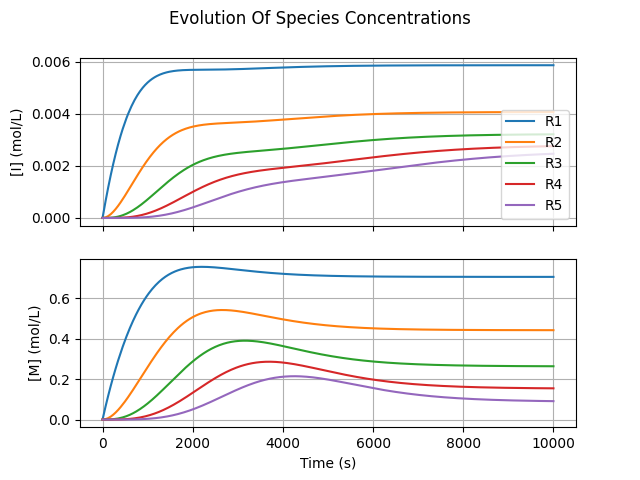

In [75]:
fig1, ax = plt.subplots(2, 1, sharex=True)
fig1.suptitle("Evolution of species concentrations".title())
fig1.canvas.header_visible = False

for i in range(ncstr):
    ax[0].plot(t, C[i, 0, :], label=f"R{i+1}")  # [I] 
    ax[1].plot(t, C[i, -1, :]) # [M]

ax[0].grid(True)
ax[1].grid(True)
ax[0].set_ylabel("[I] (mol/L)")
ax[1].set_ylabel("[M] (mol/L)")
ax[-1].set_xlabel("Time (s)")
ax[0].legend(loc='lower right')
# ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, 0.98),
#           fancybox=True, ncol=ncstr)

#### Chain Length Distribution

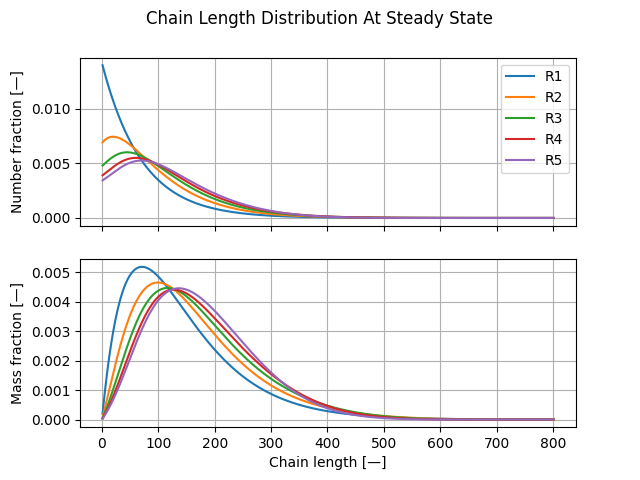

In [71]:
fig2, ax = plt.subplots(2, 1, sharex=True)
fig2.suptitle("Chain length distribution at steady state".title())
fig2.canvas.header_visible = False

# Chain length vector
N = C.shape[1] - 2
s = np.arange(1, N+1)

# Number distribution
Wn = C[:, 1:-1, :].copy()
Wn /= (Wn.sum(axis=1, keepdims=True) + 1e-15)

# Mass distribution
Wm = Wn*s[:, np.newaxis]
Wm /= (Wm.sum(axis=1, keepdims=True) + 1e-15)

for i in range(ncstr):
    ax[0].plot(s, Wn[i, :, -1], label=f"R{i+1}")
    ax[1].plot(s, Wm[i, :, -1])

ax[0].set_ylabel("Number fraction [—]")
ax[1].set_ylabel("Mass fraction [—]")
ax[-1].set_xlabel("Chain length [—]")
ax[0].grid(True)
ax[1].grid(True)
ax[0].legend(loc='upper right')
# ax[-1].set_xscale('log')

## Questions

1. What happens for $r=1$?
1. How does the PDI evolve with increasing $v$?
1. Can the molar mass distribution be used to estimate $r$? If so, under which conditions?